In [1]:
import rockhound as rh
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import sys
sys.path.insert(1, '/Users/andrew/Documents/python/pygplates_rev28_python37_MacOS64')
import pygplates
import pandas as pd
import pygmt
import cartopy.crs as ccrs
import serpentinite_spreading_grids

from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

In [2]:
def get_data(xarray):
    
    samples=10000
    tmp_ocean_crust_values = xarray
    #nan array
    NaN_locations_array = xr.ufuncs.isnan(tmp_ocean_crust_values['spreading_rate'])
    tmp_ocean_crust_values['NaN_array'] = (('lat', 'lon'), NaN_locations_array)

    peridotite_percent_values = serpentinite_spreading_grids.SR_and_peridotite(samples, tmp_ocean_crust_values['spreading_rate'],
                                                  tmp_ocean_crust_values['NaN_array'])
    #add peridotite and volcanic components to dataset
    tmp_ocean_crust_values['peridotite_percent'] = (('lat', 'lon'), peridotite_percent_values)
    tmp_ocean_crust_values['volcanic_percent'] = (('lat', 'lon'), (100 - tmp_ocean_crust_values['peridotite_percent']))

    #thickness
    thickness_values = serpentinite_spreading_grids.SR_and_thickness(samples, tmp_ocean_crust_values['spreading_rate'],
                                        tmp_ocean_crust_values['NaN_array'])
    tmp_ocean_crust_values['crustal_thickness_kms'] = (('lat', 'lon'), thickness_values)

    #serpentinisation component

    degree_of_serp_values = serpentinite_spreading_grids.degree_of_serpentinisation_of_system(tmp_ocean_crust_values['spreading_rate'].values,
                                             tmp_ocean_crust_values['crustal_thickness_kms'].values,
                                             tmp_ocean_crust_values['NaN_array'])

    tmp_ocean_crust_values['degree_of_serpentinisation'] = (('lat', 'lon'), degree_of_serp_values)

    serp_thickness = tmp_ocean_crust_values['peridotite_percent']/100 * tmp_ocean_crust_values['crustal_thickness_kms'] * \
                        tmp_ocean_crust_values['degree_of_serpentinisation']/100 * 1000/865

    tmp_ocean_crust_values['serpentinite_thickness'] = (('lat', 'lon'), serp_thickness)

    #peridotite thickness post serpent.
    perid_thickness_post_serp = tmp_ocean_crust_values['peridotite_percent']/100 * tmp_ocean_crust_values['crustal_thickness_kms'] * \
                        (1 - tmp_ocean_crust_values['degree_of_serpentinisation']/100)

    
    tmp_ocean_crust_values['peridotite_thickness_post_serpentinisation'] = (('lat', 'lon'), 
                                                                            perid_thickness_post_serp)
    return tmp_ocean_crust_values

In [3]:
#set directories
platedir = '/Users/andrew/Documents/GitHub/EarthBytePlateMotionModel-ARCHIVE/Muller++_2015_AREPS_CORRECTED/'
savedir = '/Users/andrew/Documents/scripts_output/Alberto_map/'
datadir = '/Users/andrew/Documents/Data/'

#model files
rotfile = '%sGlobal_EarthByte_230-0Ma_GK07_AREPS.rot' % platedir
COBs = '%sAgeGridInput/Global_EarthByte_230-0Ma_GK07_AREPS_COB_Terranes.gpml' % platedir
coastlines = '%sGlobal_EarthByte_230-0Ma_GK07_AREPS_Coastlines.gpml' % platedir
isochrons = '%sAgeGridInput/Global_EarthByte_230-0Ma_GK07_AREPS_Isochrons.gpml' % platedir
input_topology_filename = ['%sGlobal_EarthByte_230-0Ma_GK07_AREPS_PlateBoundaries.gpml' % platedir,
                           '%sGlobal_EarthByte_230-0Ma_GK07_AREPS_Topology_BuildingBlocks.gpml' % platedir]

rotation_model = pygplates.RotationModel(rotfile)

#topologies for our subduction points
time = 166

resolved_topologies = []
shared_boundary_sections = []

pygplates.resolve_topologies(input_topology_filename, rotation_model,
                             resolved_topologies, int(time), shared_boundary_sections)


In [7]:
from rockhound.slab2 import ZONES

# Fetch all Slab2 subduction zones and add them inside a list
subduction_zones = []
for zone in ZONES:
    subduction_zones.append(rh.fetch_slab2(zone))

#merge into global
global_sub_zones = xr.merge([grid for grid in subduction_zones])

In [8]:
# Get min and max values of the subducting plates' depths
vmax = max([grid.depth.actual_range[1] for grid in subduction_zones])
vmin = min([grid.depth.actual_range[0] for grid in subduction_zones])

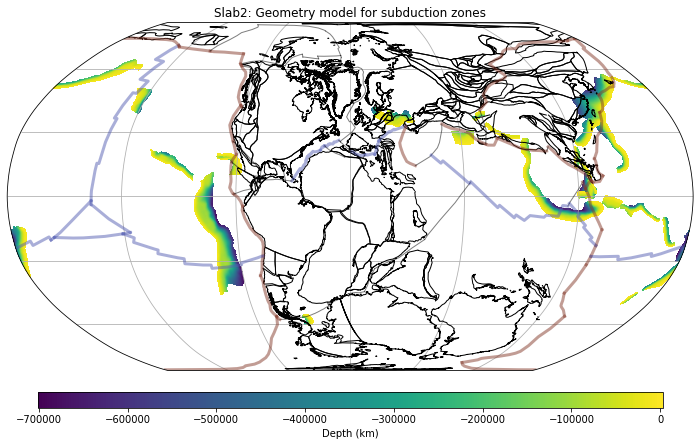

In [9]:
# Plot the depth of each subducting plate inside Slab2 with the same colorscale

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 8),
                     subplot_kw={'projection': ccrs.Robinson()})
ax.set_rasterization_zorder(2)
date_line_wrapper = pygplates.DateLineWrapper(0)
data_crs = ccrs.Geodetic()
poly_data_crs = ccrs.PlateCarree()
#ax = plt.axes(projection=ccrs.Robinson())
for grid in subduction_zones:
    pc = grid.depth.plot.pcolormesh(
        ax=ax,
        transform=ccrs.PlateCarree(),
        add_colorbar=False,
        vmin=vmin,
        vmax=vmax,
        zorder=1    )
    

ax.set_title("Slab2: Geometry model for subduction zones")
plt.colorbar(
    pc,
    ax=ax,
    label='Depth (km)',
    pad=0.05,
    aspect=40,
    shrink=0.7,
    orientation="horizontal",
)
reconstructed_polygons = []

pygplates.reconstruct(coastlines,rotation_model, reconstructed_polygons, int(time))
for polygon in reconstructed_polygons:
    poly_geom = pygplates.PolygonOnSphere(polygon.get_reconstructed_geometry())
    wrapped_polys = date_line_wrapper.wrap(poly_geom, 1)
    for wrapped_poly in wrapped_polys:
        wrapped_poly_lat = []
        wrapped_poly_lon = []
        for wrapped_poly_point in wrapped_poly.get_exterior_points():
            wrapped_poly_lat.append(wrapped_poly_point.get_latitude())
            wrapped_poly_lon.append(wrapped_poly_point.get_longitude())

        ax.plot(wrapped_poly_lon, wrapped_poly_lat, color='k', linewidth=1 ,zorder=2, transform=poly_data_crs)

for shared_boundary_section in shared_boundary_sections:
    if shared_boundary_section.get_feature().get_feature_type() == pygplates.FeatureType.gpml_mid_ocean_ridge:
        for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
            tmp = shared_sub_segment.get_resolved_geometry()
            wrapped_polylines = date_line_wrapper.wrap(tmp)
            for wrapped_polyline in wrapped_polylines:
                mor_wrapped_point_lat = []
                mor_wrapped_point_lon = []
                for wrapped_point in wrapped_polyline.get_points():
                    mor_wrapped_point_lat.append(wrapped_point.get_latitude())
                    mor_wrapped_point_lon.append(wrapped_point.get_longitude())
                ax.plot(mor_wrapped_point_lon,mor_wrapped_point_lat, color='#545eb3',
                        linewidth=3, alpha=0.5, zorder=2, transform=data_crs)

    elif shared_boundary_section.get_feature().get_feature_type() == pygplates.FeatureType.gpml_subduction_zone:
        for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
            tmp = shared_sub_segment.get_resolved_geometry()
            wrapped_polylines = date_line_wrapper.wrap(tmp)
            for wrapped_polyline in wrapped_polylines:
                mor_wrapped_point_lat = []
                mor_wrapped_point_lon = []
                for wrapped_point in wrapped_polyline.get_points():
                    mor_wrapped_point_lat.append(wrapped_point.get_latitude())
                    mor_wrapped_point_lon.append(wrapped_point.get_longitude())
                ax.plot(mor_wrapped_point_lon,mor_wrapped_point_lat, color='#853a2b',
                        linewidth=3, alpha=0.5, zorder=2, transform=data_crs)                
    else:
        for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
            tmp = shared_sub_segment.get_resolved_geometry()
            wrapped_polylines = date_line_wrapper.wrap(tmp)
            for wrapped_polyline in wrapped_polylines:
                mor_wrapped_point_lat = []
                mor_wrapped_point_lon = []
                for wrapped_point in wrapped_polyline.get_points():
                    mor_wrapped_point_lat.append(wrapped_point.get_latitude())
                    mor_wrapped_point_lon.append(wrapped_point.get_longitude())
                ax.plot(mor_wrapped_point_lon,mor_wrapped_point_lat, color='k',
                        linewidth=1, alpha=0.5, zorder=2, transform=data_crs)

ax.set_global()
gl = ax.gridlines()
gl.xlocator = mticker.FixedLocator([-180, -120, -60, 0, 60, 120, 180])
gl.ylocator = mticker.FixedLocator([-90, -60, -30, 0, 30, 60, 90])

plt.show()

#fig.savefig('/Users/andrew/Documents/Manuscripts/Merdith_2021_serpentinite_sub_zones/Slab2.pdf')

In [4]:
raster_dir = '/Users/andrew/Documents/Data/plate_model_grids/AREPS_CORRECTED-spreadrate/Mask/'

times = np.arange(166,167,1)

for time in times:
    print(time)
    spreading_rate_raster_file = '%srategrid_final_mask_%s.nc' % (raster_dir, time)
    #load datasets using netcdf4
    spreading_rate_grid = xr.open_dataset('%s' % spreading_rate_raster_file)
    #carbs = Dataset('%s' % carbon)
    #
    #for plotting
    lons = spreading_rate_grid.variables['lon'][::]
    lats = spreading_rate_grid.variables['lat'][::]
    lons_mesh, lats_mesh = np.meshgrid(lons, lats)
    ocean_crust_values = spreading_rate_grid.rename_vars({'z': 'spreading_rate'})
    #rename
    final_ocean_crust_values = get_data(ocean_crust_values)


166


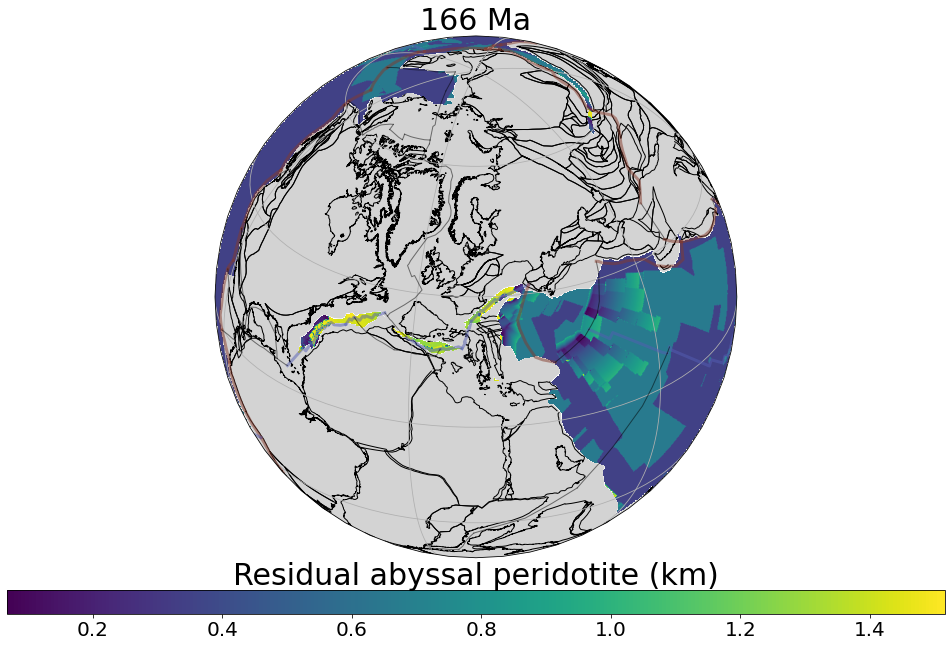

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(24,12),
                       subplot_kw={'projection': ccrs.Orthographic(central_latitude=30,
                                                                   central_longitude=15)})
cm = plt.get_cmap('viridis')
data_crs = ccrs.Geodetic()
poly_data_crs = ccrs.PlateCarree()
reconstructed_polygons = []
reconstructed_isochrons = []
reconstructed_COBs = []

# Alternative method using 'partition_geometry'
resolved_topologies = []
shared_boundary_sections = []
date_line_wrapper = pygplates.DateLineWrapper(0)

pygplates.resolve_topologies(input_topology_filename, rotation_model,
                             resolved_topologies, int(time), shared_boundary_sections)

pygplates.reconstruct(coastlines,rotation_model, reconstructed_polygons, int(time))
pygplates.reconstruct(COBs,rotation_model, reconstructed_COBs, int(time))


ax.set_global()

#limits for carbon
#v_min, v_max = 3,9 #carbon
#levels = np.linspace(v_min, v_max, 9)#carbon

CS = ax.imshow(final_ocean_crust_values['peridotite_thickness_post_serpentinisation'],
               transform=poly_data_crs, zorder=1, 
               cmap=cm, origin='lower')

for polygon in reconstructed_polygons:
    poly_geom = pygplates.PolygonOnSphere(polygon.get_reconstructed_geometry())
    wrapped_polys = date_line_wrapper.wrap(poly_geom, 1)
    for wrapped_poly in wrapped_polys:
        wrapped_poly_lat = []
        wrapped_poly_lon = []
        for wrapped_poly_point in wrapped_poly.get_exterior_points():
            wrapped_poly_lat.append(wrapped_poly_point.get_latitude())
            wrapped_poly_lon.append(wrapped_poly_point.get_longitude())

        ax.plot(wrapped_poly_lon, wrapped_poly_lat, color='k', linewidth=1 ,zorder=0, transform=poly_data_crs)

for polygon in reconstructed_COBs:
    poly_geom = pygplates.PolygonOnSphere(polygon.get_reconstructed_geometry())
    wrapped_polys = date_line_wrapper.wrap(poly_geom, 1)
    for wrapped_poly in wrapped_polys:
        wrapped_poly_lat = []
        wrapped_poly_lon = []
        for wrapped_poly_point in wrapped_poly.get_exterior_points():
            wrapped_poly_lat.append(wrapped_poly_point.get_latitude())
            wrapped_poly_lon.append(wrapped_poly_point.get_longitude())

        #ax.plot(wrapped_poly_lon, wrapped_poly_lat, color='k', linewidth=1 ,zorder=0, transform=poly_data_crs)
        ax.fill(wrapped_poly_lon, wrapped_poly_lat, color='lightgrey',
                alpha=1, linewidth=1 ,zorder=0, 
                transform=poly_data_crs)

for shared_boundary_section in shared_boundary_sections:
    if shared_boundary_section.get_feature().get_feature_type() == pygplates.FeatureType.gpml_mid_ocean_ridge:
        for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
            tmp = shared_sub_segment.get_resolved_geometry()
            wrapped_polylines = date_line_wrapper.wrap(tmp)
            for wrapped_polyline in wrapped_polylines:
                mor_wrapped_point_lat = []
                mor_wrapped_point_lon = []
                for wrapped_point in wrapped_polyline.get_points():
                    mor_wrapped_point_lat.append(wrapped_point.get_latitude())
                    mor_wrapped_point_lon.append(wrapped_point.get_longitude())
                ax.plot(mor_wrapped_point_lon,mor_wrapped_point_lat, color='#545eb3',
                        linewidth=3, alpha=0.5, zorder=2, transform=data_crs)

    elif shared_boundary_section.get_feature().get_feature_type() == pygplates.FeatureType.gpml_subduction_zone:
        for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
            tmp = shared_sub_segment.get_resolved_geometry()
            wrapped_polylines = date_line_wrapper.wrap(tmp)
            for wrapped_polyline in wrapped_polylines:
                mor_wrapped_point_lat = []
                mor_wrapped_point_lon = []
                for wrapped_point in wrapped_polyline.get_points():
                    mor_wrapped_point_lat.append(wrapped_point.get_latitude())
                    mor_wrapped_point_lon.append(wrapped_point.get_longitude())
                ax.plot(mor_wrapped_point_lon,mor_wrapped_point_lat, color='#853a2b',
                        linewidth=3, alpha=0.5, zorder=2, transform=data_crs)                
    else:
        for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
            tmp = shared_sub_segment.get_resolved_geometry()
            wrapped_polylines = date_line_wrapper.wrap(tmp)
            for wrapped_polyline in wrapped_polylines:
                mor_wrapped_point_lat = []
                mor_wrapped_point_lon = []
                for wrapped_point in wrapped_polyline.get_points():
                    mor_wrapped_point_lat.append(wrapped_point.get_latitude())
                    mor_wrapped_point_lon.append(wrapped_point.get_longitude())
                ax.plot(mor_wrapped_point_lon,mor_wrapped_point_lat, color='k',
                        linewidth=1, alpha=0.5, zorder=2, transform=data_crs)


#cbaxes = fig.add_axes([0, -0.15, 1, 0.1]) 
cbar = fig.colorbar(CS,ax=ax,
                    pad=0.05,
                    aspect=40,
                    shrink=0.7,
                    orientation="horizontal")
cbar.ax.tick_params(labelsize=20) 
cbar.ax.set_title('Residual abyssal peridotite (km)', fontsize=30)

ax.set_title('%s Ma' % int(time), fontsize=30)
gl = ax.gridlines()
gl.xlocator = mticker.FixedLocator([-180, -120, -60, 0, 60, 120, 180])
gl.ylocator = mticker.FixedLocator([-90, -60, -30, 0, 30, 60, 90])
#lon left, lon right, lat top, lat bot
#ax.set_extent([0, 30, 40, 10], crs=ccrs.PlateCarree())
fig.savefig('%sRAP_166.pdf' % savedir)

In [40]:
#load csv data of syracuse
df_syracuse = pd.read_csv('%ssyracuse_thermal/Table_2_sub_parameters.csv' % datadir)

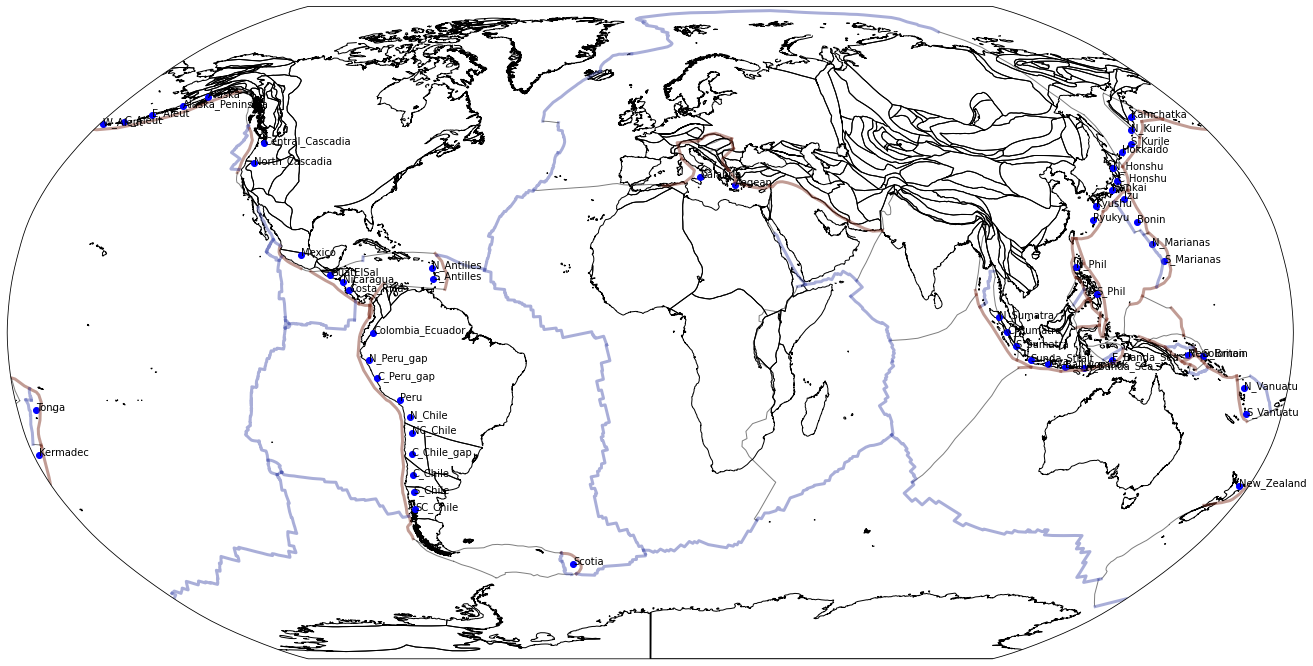

In [81]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(24,12),
                       subplot_kw={'projection': ccrs.Robinson()})
ax.set_global()
cm = plt.get_cmap('viridis')
reconstructed_polygons = []
reconstructed_isochrons = []
reconstructed_COBs = []

# Alternative method using 'partition_geometry'
resolved_topologies = []
shared_boundary_sections = []

pygplates.resolve_topologies(input_topology_filename, rotation_model,
                             resolved_topologies, int(time), shared_boundary_sections)

pygplates.reconstruct(coastlines,rotation_model, reconstructed_polygons, int(time))
pygplates.reconstruct(COBs,rotation_model, reconstructed_COBs, int(time))



for polygon in reconstructed_polygons:
    poly_geom = pygplates.PolygonOnSphere(polygon.get_reconstructed_geometry())
    wrapped_polys = date_line_wrapper.wrap(poly_geom, 1)
    for wrapped_poly in wrapped_polys:
        wrapped_poly_lat = []
        wrapped_poly_lon = []
        for wrapped_poly_point in wrapped_poly.get_exterior_points():
            wrapped_poly_lat.append(wrapped_poly_point.get_latitude())
            wrapped_poly_lon.append(wrapped_poly_point.get_longitude())

        ax.plot(wrapped_poly_lon, wrapped_poly_lat, color='k', linewidth=1 ,zorder=0, transform=poly_data_crs)

for shared_boundary_section in shared_boundary_sections:
    if shared_boundary_section.get_feature().get_feature_type() == pygplates.FeatureType.gpml_mid_ocean_ridge:
        for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
            tmp = shared_sub_segment.get_resolved_geometry()
            wrapped_polylines = date_line_wrapper.wrap(tmp)
            for wrapped_polyline in wrapped_polylines:
                mor_wrapped_point_lat = []
                mor_wrapped_point_lon = []
                for wrapped_point in wrapped_polyline.get_points():
                    mor_wrapped_point_lat.append(wrapped_point.get_latitude())
                    mor_wrapped_point_lon.append(wrapped_point.get_longitude())
                ax.plot(mor_wrapped_point_lon,mor_wrapped_point_lat, color='#545eb3',
                        linewidth=3, alpha=0.5, zorder=2, transform=data_crs)

    elif shared_boundary_section.get_feature().get_feature_type() == pygplates.FeatureType.gpml_subduction_zone:
        for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
            tmp = shared_sub_segment.get_resolved_geometry()
            wrapped_polylines = date_line_wrapper.wrap(tmp)
            for wrapped_polyline in wrapped_polylines:
                mor_wrapped_point_lat = []
                mor_wrapped_point_lon = []
                for wrapped_point in wrapped_polyline.get_points():
                    mor_wrapped_point_lat.append(wrapped_point.get_latitude())
                    mor_wrapped_point_lon.append(wrapped_point.get_longitude())
                ax.plot(mor_wrapped_point_lon,mor_wrapped_point_lat, color='#853a2b',
                        linewidth=3, alpha=0.5, zorder=2, transform=data_crs)                
    else:
        for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
            tmp = shared_sub_segment.get_resolved_geometry()
            wrapped_polylines = date_line_wrapper.wrap(tmp)
            for wrapped_polyline in wrapped_polylines:
                mor_wrapped_point_lat = []
                mor_wrapped_point_lon = []
                for wrapped_point in wrapped_polyline.get_points():
                    mor_wrapped_point_lat.append(wrapped_point.get_latitude())
                    mor_wrapped_point_lon.append(wrapped_point.get_longitude())
                ax.plot(mor_wrapped_point_lon,mor_wrapped_point_lat, color='k',
                        linewidth=1, alpha=0.5, zorder=2, transform=data_crs)
                
for row in df_syracuse.iterrows():
    ax.scatter(row[1][1], row[1][2], c='blue', transform=poly_data_crs)
    ax.text(row[1][1], row[1][2], row[1][0], transform=poly_data_crs)
    
fig.savefig('/Users/andrew/Documents/Manuscripts/Merdith_2021_serpentinite_sub_zones/syracuse.pdf')

In [56]:
df_syracuse[:3]

,Name,Lon,Lat,H (km),Arc-trench distance,Slab dip,Vc (km/Ma),Age (Ma),Descent rate (km/Ma),Thermal parameter/100 (km),Sediment thickness (km),Subducted sediment thickness (km),Upper plate type,Upper plate thickness (km),Upper plate age (Ma)
0,Aegean,25.40,36.40,120.0,250.0,30.5,15.0,200.0,7.6,15.2,4,1.0,Continental,35.0,NaN
1,Alaska,-153.55,58.87,97.0,371.0,42.0,49.0,47.1,33.0,15.6,2,0.4,Continental,35.0,NaN
2,Alaska_Peninsula,-158.80,56.53,108.0,280.0,45.0,59.0,52.2,41.8,22.0,0.8,0.4,Continental,40.0,NaN


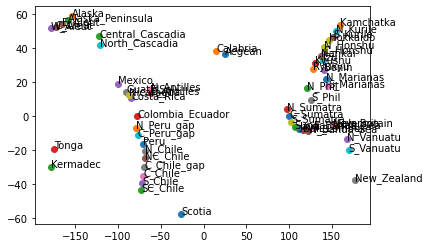

In [72]:
for row in df_syracuse.iterrows():
    plt.scatter(row[1][1], row[1][2])
    plt.text(row[1][1], row[1][2], row[1][0])

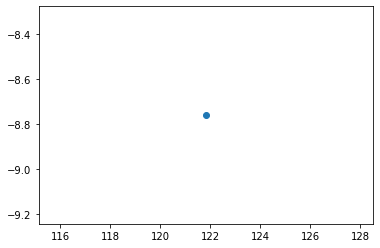

In [66]:
plt.scatter(row[1][1], row[1][2])